In [1]:
import numpy as np
from numpy.random import normal as norm
from matplotlib import pyplot as plt
import random
np.random.seed(26)

# Genetare biased distribution
# real quality q0 is from N(0, 1)
# d - discrimination against 1s
# f - fraction of indviduals having property having hidden (second) property
# N - number of people

def generate(d = [0.5, 0.5], f = [0.5, 0.5], N = [2000, 2000]):
    # size of groups
    s = [(1 - f[0]) * N[0], f[0] * N[0], (1 - f[1]) * N[1], f[1] * N[1]]
    s = [int(x) for x in s]
    # vector of properties
    a = [(0,0)] * s[0] + [(0,1)] * s[1] + [(1,0)] * s[2] + [(1,1)] * s[3]
    m = 0
    st = 1
    q0 = norm(m, st, len(a))
    # creating bias
    bias = [0 for i in range(s[0])] + [-d[1] * st for i in range(s[1])] + [-d[0] * st for i in range(s[2])] + [-d[1] * st - d[0] * st for i in range(s[3])]
    q = q0 + bias    
    # shuffling the results
    rnd = [x for x in range(len(a))]
    random.shuffle(rnd)
    q = [q[i] for i in rnd]
    a = [a[i] for i in rnd]    
    q0 = [q0[i] for i in rnd]
    # return vectors of properties, perceived qualities and real qualities
    return a, q, q0

# return individuals with top percieved qualities
def getTop(a, q, top = 0.1):    
    top = int(len(q) * top)
    ordered = [i for i in sorted(zip(q, a), reverse = True)]
    return ordered[:top]
         
# return individuals top individuals after debiasing
def getTopDebiased(a, q, top = 0.1):
    # Debiasing is always on the visible (first) attribute 
    # Allocate proportional quotas
    quota_1 = int(len([x for x in a if x[0] == 1]) * top)
    quota_0 = int(len([x for x in a if x[0] == 0]) * top)
 
    ordered = [i for i in sorted(zip(q, a), reverse = True)]   
 
    return [x for x in ordered if x[1][0] == 0][:quota_0] + [x for x in ordered if x[1][0] == 1][:quota_1]
 


In [2]:
# Compute chances to be in top k% for aggregated groups before and after debiasing
def get_aggregated(d, f, Nsim, k_range):
    results = {'original': {0: [], 1: []},
               'debiased': {0: [], 1: []}}

    groups = [0, 1]

    for k in k_range:    
        simulations = {'original': {0: [], 1: []},
                       'debiased': {0: [], 1: []}}

        for i in range(0, Nsim):
            a, q, q0 = generate(d, f)
            
            for group in groups:
                # compute expected chances to be in top
                exp = len([x for x in a if x[0] == group]) / len(q)

                for approach in ['original', 'debiased']:
                    if approach == 'original':
                       top = getTop(a, q, k)
                    else:
                       top = getTopDebiased(a, q, k)
                    # compute real chances to be in top
                    real = len([x for x in top if x[1][0] == group]) / len(top)
                    simulations[approach][group].append((real - exp) / exp)

        for group in [0, 1]:
            for approach in ['original', 'debiased']:
                results[approach][group].append(np.mean(simulations[approach][group]))
    return results

def plot_aggregated(results):
    colors = ['orange', 'green']
    styles = {'original': '-', 'debiased': '--'}

    for approach in ['original', 'debiased']:
        for group in [0, 1]:
            plt.plot(k_range, results[approach][group], color = colors[group], ls = styles[approach])
    plt.xlabel('top k')
    plt.ylabel('representation bias')

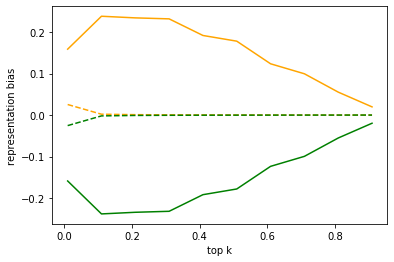

In [3]:
# for quick results
Nsim = 5
k_range = [i / 100 for i in range(1, 101, 10)]

# for better simulations (be careful: 200 times longer)
# Nsim = 100
# k_range = [i / 100 for i in range(1, 101)]

d = [-0.5, 1.5]
f = [0.2, 0.8]

results = get_aggregated(d, f, Nsim, k_range)
plot_aggregated(results)


In [4]:
# Compute chances to be in top k% for disaggregated groups before and after debiasing
def get_disaggregated(d, f, Nsim, k_range):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    
    results = {'original': {g:[] for g in groups},
               'debiased': {g:[] for g in groups}}

    for k in k_range:    
        simulations = {'original': {g:[] for g in groups},
                       'debiased': {g:[] for g in groups}}
        
        for i in range(0, Nsim):
            a, q, q0 = generate(d, f)
            
            for g in groups:
                # compute expected chances to be in top
                exp = len([x for x in a if x == g]) / len(q)
                
                for approach in ['original', 'debiased']:
                    if approach == 'original':
                       top = getTop(a, q, k)
                    else:
                       top = getTopDebiased(a, q, k)
                    # compute real chances to be in top
                    real = len([x for x in top if x[1] == g]) / len(top)
                    simulations[approach][g].append((real - exp) / exp)

        for g in groups:
            for approach in ['original', 'debiased']:
                results[approach][g].append(np.mean(simulations[approach][g]))
    return results

def plot_disaggregated(results):
    groups = [(0,0),(0,1),(1,0),(1,1)]
    fill = {'original': 'full', 'debiased': 'none'}
    colors = ['orange', 'green']
    shapes = ['o', '*']
    #ms = [6, 9, 6, 9]

    for g in groups:
        for approach in ['original', 'debiased']:            
            plt.plot(k_range, results[approach][g], shapes[g[1]], color = colors[g[0]], lw = 2, fillstyle = fill[approach])
            
    plt.xlabel('top k')
    plt.ylabel('representation bias')

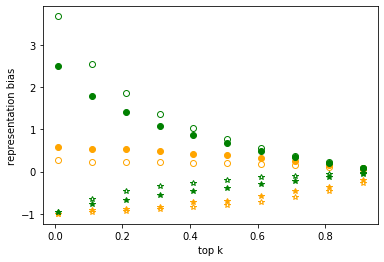

In [5]:
# for quick results
Nsim = 5
k_range = [i / 100 for i in range(1, 101, 10)]

# for better simulations (be careful: 200 times longer)
# Nsim = 100
# k_range = [i / 100 for i in range(1, 101)]

d = [-0.5, 1.5]
f = [0.2, 0.8]

results = get_disaggregated(d, f, Nsim, k_range)
plot_disaggregated(results)

In [16]:
# compute performance (average real quality) of top individuals
# as we know penalties we could easily restore real quality from the observed
def performance(top, d):
    result = 0
    for entry in top:
        result += entry[0] + entry[1][0] * d[0] + entry[1][1] * d[1]
    return result / len(top)
 
def get_performance(f, Nsim, tp, dh_range, dv_range):
    result = {}
    for dv in dv_range:
        result[dv] = {}
        print(dv, end =" ") # for long computations to track the progress
        for dh in dh_range:             
            d = [dv, dh]
            
            original = 0; debiased = 0
                                  
            for i in range(0, Nsim):
                a, q, q0 = generate(d, f)
                top = getTop(a, q, tp)
                original += performance(top, d)    
                top = getTopDebiased(a, q, tp)
                debiased += performance(top, d)
                
                 
            result[dv][dh] = (original/Nsim, debiased/Nsim)       
    print()
    return result

def plot_performance(result, dh_range, dv_range):
    colors = ['#B71C1C', '#E65100', '#FFD600', '#1B5E20', '#0091EA', '#1A237E', '#4A148C']
    plt.figure()
    for i in range(0, len(dh_range)):
        dh = dh_range[i]
        plt.plot(dv_range, [result[i][dh][0] for i in dv_range], color = colors[i], label = '$d_{shape}$ = ' + str(dh), lw = 2)
        plt.plot(dv_range, [result[i][dh][1] for i in dv_range], '--', color = colors[i], lw = 2)

    plt.xlabel('$d_{color}$')
    plt.ylabel('fairness')
    plt.legend()

-3.0 -2.3333333333333335 -1.6666666666666667 -1.0 -0.3333333333333335 0.33333333333333304 1.0 1.666666666666666 2.333333333333333 3.0 
-3.0 -2.3333333333333335 -1.6666666666666667 -1.0 -0.3333333333333335 0.33333333333333304 1.0 1.666666666666666 2.333333333333333 3.0 


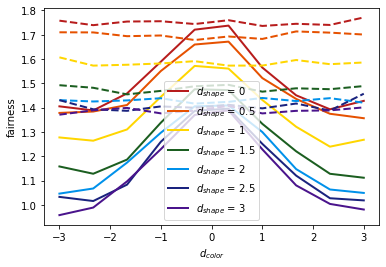

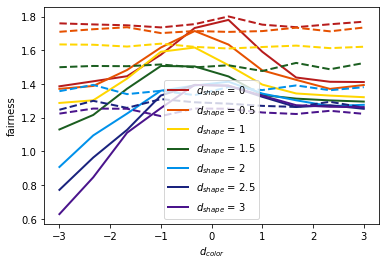

In [17]:
Nsim = 5 # increase for better simulations
tp = 0.1
dh_range = [0, 0.5, 1, 1.5, 2, 2.5, 3]
dv_range = np.linspace(-3, 3, 10)

# result for uncorrelated attributes
f = [0.5, 0.5]
result = get_performance(f, Nsim, tp, dh_range, dv_range)
plot_performance(result, dh_range, dv_range)

# results for correlated attributes 
f = [0.2, 0.8]
result = get_performance(f, Nsim, tp, dh_range, dv_range)
plot_performance(result, dh_range, dv_range)


